# **Diplomado IA: Inteligencia Artificial II - Parte 2**. <br> Práctico 1: Aprendizaje Incremental y  Olvido Catastrófico
---
---

**Profesores:**
- Julio Hurtado
- Pablo Messina

**Ayudante:**
- 

---
---

Tarea es individual

# Introducción

Este laboratorio se basó en una serie de Notebooks del grupo [Continual AI](https://https://www.continualai.org/), la cual es una comunidad abierta que busca desarrollar investigación y divulgación sobre Aprendizaje Continuo.
 
Tal como vimos en clases, el aprendizaje incremental estudia modelos y métodos que permitan un proceso de aprendizaje continuo de varias tareas diferentes.
 
En este laboratorio vamos a ver cómo se comportan diferentes métodos simples en una secuencia de tareas muy utilizadas para comparación entre métodos.


Lo primero que tenemos que hacer es verificar cómo están los niveles de memoria y disco. Luego verificamos si tenemos acceso a GPU.

In [4]:
!free -m
!df -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:          13021         553       10435           0        2031       12196
Swap:             0           0           0
Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   39G   30G  57% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   24K  6.4G   1% /var/colab
/dev/sda1        75G   40G   35G  54% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
Sun Mar 14 22:18:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id      

In [5]:
import torch
torch.cuda.is_available()

True

Cargamos todas las librerias que vamos a utilziar durante este laboratorio

In [6]:
import random
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Modelo

In [7]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1);

El modelo consiste en 2 capas convolucionales más dos capas lineales, se agregan capas de max pooling y funciones de activación. 
 
El modelo utilizado es simple ya que la motivación no es lograr los mejores resultados en cada tarea, sino que nos permite reflejar lo que ocurre cuando no tenemos precauciones al entrenar una nueva tarea.


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# Dataset

En este laboratorio vamos a utilizar el dataset *MNIST* (LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.). Este dataset consiste en 60.000 imágenes de 28x28 pixeles, y cada una es una imagen de un dígito del 0 al 9 escrita a mano. Es decir, tiene 10 clases diferentes (una por dígito).
 
Por simplicidad vamos a utilizar las funciones de descarga de Continual AI, ya que nos va a facilitar la creación de nuevas tareas. 


In [9]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 213 (delta 48), reused 69 (delta 32), pack-reused 120
Receiving objects: 100% (213/213), 10.19 MiB | 32.01 MiB/s, done.
Resolving deltas: 100% (90/90), done.


Descargamos el dataset en nuestro entorno de colab

In [10]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.



Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Luego lo cargamos a memoria.
 
El dataset que estamos utilizando es muy simple, ideal para hacer pruebas de concepto, ya que tiene varias imagenes pequeñas. Al ser pequeñas, estas se pueden cargar en memoria completamente, lo que acelera bastante el proceso de entrenamiento.
 
Lo bueno de probar estos métodos en pequeños dataset es que nos permite validar nuestra propuesta antes de consumir horas o días de computo probando en otra secuencia de tareas. Pero una vez que validamos las ideas, podemos probar los mismos métodos en otras tareas.

In [11]:
x_train, y_train, x_test, y_test = mnist.load()

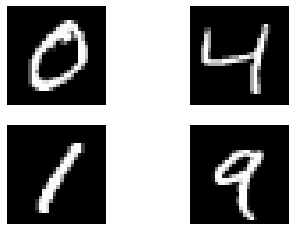

In [12]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

## Permuted MNIST

Esta secuencia de tareas consiste en tomar cada imagen del set original del dataset MNIST, y realizar una permutación de los pixeles para que refleje otros patrones en la imagen.
 
Cada tarea que queremos agregar es una nueva permutación que se hace a cada una de las imágenes. Por ejemplo, una nueva tarea puede ser mover todos los píxeles uno a la derecha. Pero lo que se hace normalmente es que cada tarea es una permutación aleatoria de todos los píxeles, buscando generar patrones únicos en cada tarea.

In [14]:
def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    print("done.")
    return perm_mnist

starting permutation...
done.


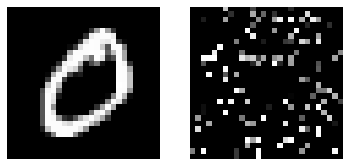

In [15]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 0)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[1, 0], cmap="gray")
axarr[1].imshow(x_train2[2, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

starting permutation...
done.


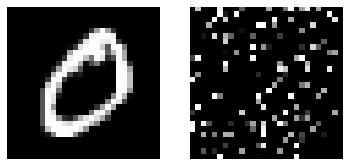

In [16]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 5)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[1, 0], cmap="gray")
axarr[1].imshow(x_train2[2, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

# Entrenamiento

Tal como en laboratorios anteriores, tenemos dos funciones que nos ayudan a entrenar e ir verificando cómo van los entrenamientos de nuestro modelo.
 
**train**: Es la encargada de entrenar el modelo con los datos que le entregamos. Estos deben ser de la tarea actual.
 
**test**: Nos devuelve el accuracy logrado por el modelo con los datos que le entregamos.

In [17]:
def train(model, device, x_train, y_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(y_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(y_train[start:end]).long()
        x, y = x.to(device), y.to(device)
      
        optimizer.zero_grad()

        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, y_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(y_test)-1, 256):
       end = start + 256
       with torch.no_grad():
          x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(y_test[start:end]).long()
          x, y = x.to(device), y.to(device)
          output = model(x)
          test_loss += F.cross_entropy(output, y).item() # sum up batch loss
          pred = output.max(1, keepdim=True)[1] # get the index of the max logit
          correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(y_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(y_test),
        100. * correct / len(y_test)))
    return 100. * correct / len(y_test)

Es importante inicializar el modelo cada vez que queramos entrenar una nueva secuencia, ya que si no lo hacemos estamos partiendo con un modelo que ya tiene información de alguna tarea en sus pesos.

In [14]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [15]:
for epoch in range(1, 5):
   train(model, device, x_train, y_train, optimizer, epoch)
   test(model, device, x_test, y_test)

Train Epoch: 1 	Loss: 0.754571
Test set: Average loss: 0.0013, Accuracy: 9015/10000 (90%)

Train Epoch: 2 	Loss: 0.504929
Test set: Average loss: 0.0007, Accuracy: 9433/10000 (94%)

Train Epoch: 3 	Loss: 0.467992
Test set: Average loss: 0.0006, Accuracy: 9548/10000 (95%)

Train Epoch: 4 	Loss: 0.456822
Test set: Average loss: 0.0005, Accuracy: 9619/10000 (96%)



Con los resultados anteriores, podemos ver que el modelo logró un muy buen rendimiento en la tarea con los datos original. Lo mejor, es que no necesita una gran cantidad de épocas para alcanzar esos resultados.

## Olvido Catastrófico

El mayor problema que tiene el aprender tareas de manera secuencial es lo que se conoce como Olvido Catastrófico, donde al entrenar una nueva tarea, el rendimiento alcanzado en tareas anteriores se ve fuertemente afectado.

Primero veamos el accuracy que alcanza un modelo en dos tareas, cuando fue entrenado solo en la primera:

In [16]:
print("Testing on the first task:")
test(model, device, x_test, y_test)

print("Testing on the second task:")
test(model, device, x_test2, y_test);

Testing on the first task:
Test set: Average loss: 0.0005, Accuracy: 9619/10000 (96%)

Testing on the second task:
Test set: Average loss: 0.0099, Accuracy: 1034/10000 (10%)



Como era esperado, a nuestro modelo no le va bien en una tarea en la cual no ha sido entrenado. Esto se refleja más todavía cuando las imágenes entre las tareas son bien diferentes.
 
Debido a lo anterior, es necesario entrenar el modelo en este nuevo dataset para que adquiera los conocimientos necesarios, y se pueda desempeñar de manera correcta en esta nueva tarea.


In [17]:
for epoch in range(1, 3):
  train(model, device, x_train2, y_train, optimizer, epoch)
  test(model, device, x_test2, y_test)

Train Epoch: 1 	Loss: 1.241655
Test set: Average loss: 0.0031, Accuracy: 7567/10000 (76%)

Train Epoch: 2 	Loss: 0.990397
Test set: Average loss: 0.0022, Accuracy: 8254/10000 (83%)



In [18]:
print("Testing on the first task:")
test(model, device, x_test, y_test)

print("Testing on the second task:")
test(model, device, x_test2, y_test);

Testing on the first task:
Test set: Average loss: 0.0148, Accuracy: 3595/10000 (36%)

Testing on the second task:
Test set: Average loss: 0.0022, Accuracy: 8254/10000 (83%)



Pero tal como vimos en clases, se produce el problema de olvido catastrófico, donde obtenemos un buen rendimiento en la segunda tarea pero en la primera tarea olvidamos casi todo lo aprendido.

# Estrategias de Aprendizaje Continuo

En este laboratorio vamos a comprobar el rendimiento de 3 metodos diferentes:

1.   Naive: Entrenamiento sin ningun tipo de metodo preocupado de alivianar el problema del olvido
2.   Rehearsal: Tener una memoria con datos de tareas pasadas
3.   Elastic Weight Consolidation (EWC): Uno de los metodo que vimos en clases

Primero vamos a crear las diferentes tareas que vamos a utilizar. La variable *num_tasks* es la encargada de determinar la cantidad de tareas que vamos a probar, y *num_epoch* por cuantas iteraciones vamos a entrenar cada tarea.

In [18]:
num_tasks = 3
num_epoch = 3
tasks = []
for i in range(num_tasks):
    if i > 0:
        train_x, test_x = permute_mnist([x_train, x_test], i)
        task = [(train_x, y_train), (test_x, y_test)]
    else:
        task = [(x_train, y_train), (x_test, y_test)]
    
    tasks.append(task)

starting permutation...
done.
starting permutation...
done.


## Naive Strategy

A modo de *baseline*, vamos a entrenar el modelo con la estrategia más simple.  Esta consiste en entrenar de manera secuencial todas las tareas sin ningún tipo de estrategia contra el olvido.

In [61]:
modelOG = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [62]:
naive_accs = []

for id, task in enumerate(tasks):
    avg_acc = 0
    print("Training on task: ", id)
  
    (x_train, y_train), _ = task
  
    for epoch in range(1, num_epoch):
        train(modelOG, device, x_train, y_train, optimizer, epoch)
    
    for id_test, task in enumerate(tasks):
        print("Testing on task: ", id_test)
        _, (x_test, y_test) = task
        acc = test(modelOG, device, x_test, y_test)
        avg_acc = avg_acc + acc 
  
    naive_accs.append(avg_acc / 3)
    print("Avg acc: ", avg_acc / 3)
  

Training on task:  0
Train Epoch: 1 	Loss: 2.303092
Train Epoch: 2 	Loss: 2.317416
Testing on task:  0
Test set: Average loss: 0.0092, Accuracy: 867/10000 (9%)

Testing on task:  1
Test set: Average loss: 0.0092, Accuracy: 983/10000 (10%)

Testing on task:  2
Test set: Average loss: 0.0092, Accuracy: 927/10000 (9%)

Testing on task:  3
Test set: Average loss: 0.0092, Accuracy: 747/10000 (7%)

Testing on task:  4
Test set: Average loss: 0.0092, Accuracy: 828/10000 (8%)

Avg acc:  14.506666666666668
Training on task:  1
Train Epoch: 1 	Loss: 2.313515
Train Epoch: 2 	Loss: 2.320403
Testing on task:  0
Test set: Average loss: 0.0092, Accuracy: 867/10000 (9%)

Testing on task:  1
Test set: Average loss: 0.0092, Accuracy: 983/10000 (10%)

Testing on task:  2
Test set: Average loss: 0.0092, Accuracy: 927/10000 (9%)

Testing on task:  3
Test set: Average loss: 0.0092, Accuracy: 747/10000 (7%)

Testing on task:  4
Test set: Average loss: 0.0092, Accuracy: 828/10000 (8%)

Avg acc:  14.5066666666

### Actividad Practica 1

- ¿Afecta el orden de las tareas? Por ejemplo si invertimos el orden de las tareas, entrenando la última, luego la penúltima, se ven resultados diferentes?
- ¿Cómo afecta el rendimiento promedio de este método cuando agregamos más tareas?

*Respuesta*

1) Como se observa aqui abajo en el calculo, al cambiar el orden de las tareas se observa el mismo patron, es decir, la tarea que se esta entrenando en cada epoch tiene la mejor accuracy, y las otras dos tareas decrecen en accuracy.

In [24]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [25]:
# Experimentos aquí #

nuevo_orden_tarea = [tasks[2], tasks[1], tasks[0]]

naive_accs = []

for id, task in enumerate(nuevo_orden_tarea):
    avg_acc = 0
    print("Training on task: ", id)
  
    (x_train, y_train), _ = task
  
    for epoch in range(1, num_epoch):
        train(model, device, x_train, y_train, optimizer, epoch)
    
    for id_test, task in enumerate(nuevo_orden_tarea):
        print("Testing on task: ", id_test)
        _, (x_test, y_test) = task
        acc = test(model, device, x_test, y_test)
        avg_acc = avg_acc + acc 
  
    naive_accs.append(avg_acc / 3)
    print("Avg acc: ", avg_acc / 3)
  

Training on task:  0
Train Epoch: 1 	Loss: 2.045251
Train Epoch: 2 	Loss: 1.012216
Testing on task:  0
Test set: Average loss: 0.0028, Accuracy: 7942/10000 (79%)

Testing on task:  1
Test set: Average loss: 0.0103, Accuracy: 1352/10000 (14%)

Testing on task:  2
Test set: Average loss: 0.0289, Accuracy: 1054/10000 (11%)

Avg acc:  34.49333333333333
Training on task:  1
Train Epoch: 1 	Loss: 0.947041
Train Epoch: 2 	Loss: 0.797456
Testing on task:  0
Test set: Average loss: 0.0065, Accuracy: 4227/10000 (42%)

Testing on task:  1
Test set: Average loss: 0.0017, Accuracy: 8721/10000 (87%)

Testing on task:  2
Test set: Average loss: 0.0402, Accuracy: 423/10000 (4%)

Avg acc:  44.56999999999999
Training on task:  2
Train Epoch: 1 	Loss: 1.114115
Train Epoch: 2 	Loss: 0.692899
Testing on task:  0
Test set: Average loss: 0.0096, Accuracy: 1350/10000 (14%)

Testing on task:  1
Test set: Average loss: 0.0117, Accuracy: 841/10000 (8%)

Testing on task:  2
Test set: Average loss: 0.0012, Accurac

RESPUESTA 2) Al agregar mas tareas se observa el mismo patron, es decir, la tarea que se esta entrenando tiene el mejor accuracy, mientras que el resto baja en su accuracy. Con respecto al accuracy promedio, subió levemente, de un 45% a un 55% al usar 5 tareas, Codigo aqui abajo:

In [35]:
num_tasks = 5
num_epoch = 3
tasks = []
for i in range(num_tasks):
    if i > 0:
        train_x, test_x = permute_mnist([x_train, x_test], i)
        task = [(train_x, y_train), (test_x, y_test)]
    else:
        task = [(x_train, y_train), (x_test, y_test)]
    
    tasks.append(task)

starting permutation...
done.
starting permutation...
done.
starting permutation...
done.
starting permutation...
done.


In [36]:
len(tasks)

5

In [37]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [38]:
# Experimentos aquí #

naive_accs = []

for id, task in enumerate(tasks):
    avg_acc = 0
    print("Training on task: ", id)
  
    (x_train, y_train), _ = task
  
    for epoch in range(1, num_epoch):
        train(model, device, x_train, y_train, optimizer, epoch)
    
    for id_test, task in enumerate(tasks):
        print("Testing on task: ", id_test)
        _, (x_test, y_test) = task
        acc = test(model, device, x_test, y_test)
        avg_acc = avg_acc + acc 
  
    naive_accs.append(avg_acc / 3)
    print("Avg acc: ", avg_acc / 3)
  

Training on task:  0
Train Epoch: 1 	Loss: 1.889102
Train Epoch: 2 	Loss: 0.896592
Testing on task:  0
Test set: Average loss: 0.0029, Accuracy: 7985/10000 (80%)

Testing on task:  1
Test set: Average loss: 0.0098, Accuracy: 1796/10000 (18%)

Testing on task:  2
Test set: Average loss: 0.0110, Accuracy: 1320/10000 (13%)

Testing on task:  3
Test set: Average loss: 0.0112, Accuracy: 813/10000 (8%)

Testing on task:  4
Test set: Average loss: 0.0109, Accuracy: 1119/10000 (11%)

Avg acc:  43.443333333333335
Training on task:  1
Train Epoch: 1 	Loss: 0.844432
Train Epoch: 2 	Loss: 0.650373
Testing on task:  0
Test set: Average loss: 0.0059, Accuracy: 4802/10000 (48%)

Testing on task:  1
Test set: Average loss: 0.0018, Accuracy: 8755/10000 (88%)

Testing on task:  2
Test set: Average loss: 0.0110, Accuracy: 1051/10000 (11%)

Testing on task:  3
Test set: Average loss: 0.0106, Accuracy: 1019/10000 (10%)

Testing on task:  4
Test set: Average loss: 0.0107, Accuracy: 792/10000 (8%)

Avg acc: 

## Rehearsal Strategy

Una manera simple de no perder rendimiento en tareas pasadas es la de ir acumulando los datos en un gran dataset, de manera de siempre tener la distribución de los datos antiguos y nuevos disponible. Existen tres problemas con esto:
* El costo computacional de entrenar el modelo con cada vez más datos
* El costo en memoria, al ir guardando todos los datos aumenta
* El costo en privacidad que tiene guardar estos datos
 
Una alternativa a guardar todos los datos, podemos guardar un porcentaje de los datos de tareas anteriores, alivianando en parte los problemas mencionados. Pero cómo vamos a ver a continuación, existe un trade-off entre la cantidad de datos que estamos guardando y el rendimiento que podemos alcanzar.




In [28]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

Luego tenemos que re-inicializar el modelo para no partir de una base previamente entrenada y tener una comparación más justa.

In [29]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [30]:
rehe_accs = []
num_past_elem = 1000 #50000 -> Dataset total

for id, task in enumerate(tasks):
    avg_acc = 0
    print("Training on task: ", id)
  
    (x_train, y_train), _ = task
  
    # for previous task
    for i in range(id):
        (past_x_train, past_y_train), _ = tasks[i]
        idx = random.sample(list(range(len(past_y_train))), num_past_elem)
        x_train = np.concatenate((x_train, past_x_train[idx]))
        y_train = np.concatenate((y_train, past_y_train[idx]))
  
    x_train, y_train = shuffle_in_unison([x_train, y_train], 0)
  
    for epoch in range(1, num_epoch):
        train(model, device, x_train, y_train, optimizer, epoch)
    
    for id_test, task in enumerate(tasks):
        print("Testing on task: ", id_test)
        _, (x_test, y_test) = task
        acc = test(model, device, x_test, y_test)
        avg_acc = avg_acc + acc
   
    print("Avg acc: ", avg_acc / len(tasks))
    rehe_accs.append(avg_acc/len(tasks))

Training on task:  0
Train Epoch: 1 	Loss: 0.523789
Train Epoch: 2 	Loss: 0.346071
Testing on task:  0
Test set: Average loss: 0.0007, Accuracy: 9470/10000 (95%)

Testing on task:  1
Test set: Average loss: 0.0112, Accuracy: 713/10000 (7%)

Testing on task:  2
Test set: Average loss: 0.0097, Accuracy: 1181/10000 (12%)

Avg acc:  37.88
Training on task:  1
Train Epoch: 1 	Loss: 1.437485
Train Epoch: 2 	Loss: 1.052907
Testing on task:  0
Test set: Average loss: 0.0024, Accuracy: 8223/10000 (82%)

Testing on task:  1
Test set: Average loss: 0.0026, Accuracy: 8098/10000 (81%)

Testing on task:  2
Test set: Average loss: 0.0098, Accuracy: 1544/10000 (15%)

Avg acc:  59.550000000000004
Training on task:  2
Train Epoch: 1 	Loss: 1.093941
Train Epoch: 2 	Loss: 1.055043
Testing on task:  0
Test set: Average loss: 0.0028, Accuracy: 7985/10000 (80%)

Testing on task:  1
Test set: Average loss: 0.0054, Accuracy: 5558/10000 (56%)

Testing on task:  2
Test set: Average loss: 0.0020, Accuracy: 8488/1

### Actividad Práctica 2

*  Gráfique cómo evoluciona el accuracy promedio con diferentes valores de *num_past_elem*. Explique los resultados.
*  Explique el trade-off que existe entre el accuracy logrado y la memoria utilizada por los datos anteriores. Puede utilizar [getsizeof](https://docs.python.org/2/library/sys.html#sys.getsizeof)
*  Porque es necesario aplicar la función *shuffle* antes de entrenar con los datos de la tarea actual y la pasada.

**RESPUESTA 1**
Grafico para distintos valores de num_past_elem:

In [58]:
modelDos = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [59]:
# Respuestas # 
lista_num_past_elem = [50, 500, 1000, 3000, 6000, 10000]

avg_accuracies = []

for num_past_elem in lista_num_past_elem:
  rehe_accs = []
  #num_past_elem = 1000 #50000 -> Dataset total

  for id, task in enumerate(tasks):
      avg_acc = 0
      print("Training on task: ", id)
    
      (x_train, y_train), _ = task
    
      # for previous task
      for i in range(id):
          (past_x_train, past_y_train), _ = tasks[i]
          idx = random.sample(list(range(len(past_y_train))), num_past_elem)
          x_train = np.concatenate((x_train, past_x_train[idx]))
          y_train = np.concatenate((y_train, past_y_train[idx]))
    
      x_train, y_train = shuffle_in_unison([x_train, y_train], 0)
    
      for epoch in range(1, num_epoch):
          train(modelDos, device, x_train, y_train, optimizer, epoch)
      
      for id_test, task in enumerate(tasks):
          print("Testing on task: ", id_test)
          _, (x_test, y_test) = task
          acc = test(modelDos, device, x_test, y_test)
          avg_acc = avg_acc + acc
    
      print("Avg acc: ", avg_acc / len(tasks))
      rehe_accs.append(avg_acc/len(tasks))

  avg_accuracies.append( np.mean(rehe_accs))

Training on task:  0
Train Epoch: 1 	Loss: 2.271771
Train Epoch: 2 	Loss: 2.303206
Testing on task:  0
Test set: Average loss: 0.0092, Accuracy: 982/10000 (10%)

Testing on task:  1
Test set: Average loss: 0.0092, Accuracy: 982/10000 (10%)

Testing on task:  2
Test set: Average loss: 0.0092, Accuracy: 982/10000 (10%)

Testing on task:  3
Test set: Average loss: 0.0092, Accuracy: 982/10000 (10%)

Testing on task:  4
Test set: Average loss: 0.0092, Accuracy: 982/10000 (10%)

Avg acc:  9.82
Training on task:  1
Train Epoch: 1 	Loss: 2.300273
Train Epoch: 2 	Loss: 2.307965
Testing on task:  0
Test set: Average loss: 0.0092, Accuracy: 982/10000 (10%)

Testing on task:  1
Test set: Average loss: 0.0092, Accuracy: 982/10000 (10%)

Testing on task:  2
Test set: Average loss: 0.0092, Accuracy: 982/10000 (10%)

Testing on task:  3
Test set: Average loss: 0.0092, Accuracy: 982/10000 (10%)

Testing on task:  4
Test set: Average loss: 0.0092, Accuracy: 982/10000 (10%)

Avg acc:  9.82
Training on ta

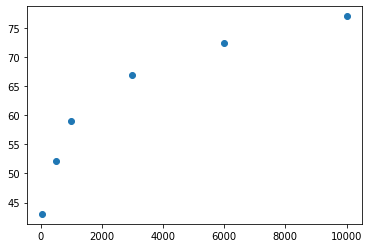

In [49]:
import matplotlib.pyplot as plt

plt.scatter(lista_num_past_elem, avg_accuracies)

El grafico muestra que el accuracy promedio (eje Y) aumenta poco a poco a medida que aumentamos Num_Past_Elem (eje X)

**RESPUESTA 2**
memoria vs accuracy:

In [63]:
import sys
print( sys.getsizeof(modelOG) )


64


In [60]:
print( sys.getsizeof(modelDos))

64


Ambos modelos me dieron el mismo valor, al usar getsizeof(). 

**RESPUESTA 3**
Se usa el shuffle para evitar que el modelo memorize los datos simplemente por su ubicación entre la tarea actual y la pasada.

## Elastic Weights Consolidation (EWC) Strategy

Como vimos en clases, EWC es una estrategia que se propuso en: "[Overcoming catastrophic forgetting in neural networks](https://arxiv.org/abs/1612.00796)".
 
Este método busca penalizar la modificación de ciertos pesos relevantes para tareas anteriores y que al modificarlos pueden provocar una reducción del rendimiento de estas tareas. Los pesos importantes se encuentran mediante la información de la matriz de Fisher, que se puede aproximar con el valor del gradiente al cuadrado.
 
Este método tiene la gran ventaja de que no necesita guardar elementos de tareas anteriores, lo cual lo hace eficiente con el uso de la memoria.

In [19]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.4

In [20]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Necesitamos una función que nos entregue la importancia de cada peso para cada una de las tareas, ya que como podemos ver en la siguiente ecuación:
 
> $L_{EWC} = \sum_i \frac{\lambda}{2} F_i (\theta_i - \theta_{A,i}^*) $
 
Cada peso tiene un valor asociado, si este valor es alto implica que es un peso importante y cambiarlo mucho aumentaría el valor de la función de pérdida.

Tal como dijimos en clases, el valor de $F_i$ se puede aproximar con el gradiente:
 
> $ F_i =  g_i^2 $


In [21]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()
  
  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():
    
      optpar_dict[task_id][name] = param.data.clone()
      fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

Como es una estrategia de regularización, necesitamos cambiar nuestra función de pérdida para agregar el el valor descrito anteriormente:
 
> $ L = L_T + L_{EWC} $


In [24]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch, ewc_lambda):
    model.train()

    for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)
      
        optimizer.zero_grad()

        output = model(x)
        loss = F.cross_entropy(output, y)
      
        ### EWC! :-)
        for task in range(task_id):
            for name, param in model.named_parameters():
                fisher = fisher_dict[task][name]
                optpar = optpar_dict[task][name]
                loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda
      
        loss.backward()
        optimizer.step()
        #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Con el método y las funciones ya definidas, solo nos queda entrenar nuestro modelo.

In [ ]:
ewc_accs = []
for id, task in enumerate(tasks):
    avg_acc = 0
    print("Training on task: ", id)
  
    (x_train, y_train), _ = task
  
    for epoch in range(1, 3):
        train_ewc(model, device, id, x_train, y_train, optimizer, epoch)
    on_task_update(id, x_train, y_train)
    
    for id_test, task in enumerate(tasks):
        print("Testing on task: ", id_test)
        _, (x_test, y_test) = task
        acc = test(model, device, x_test, y_test)
        avg_acc = avg_acc + acc
   
    print("Avg acc: ", avg_acc / 3)
    ewc_accs.append(avg_acc / 3)

In [25]:
ewc_accs

[36.71666666666666, 48.903333333333336, 57.95333333333334]

### Actividad Práctica 3
 
* Graficar el accuracy promedio con diferentes valores de lambda. Explique los resultados.
* Compare la memoria extra utilizada por la estrategia de Rehersal (con 500 elementos por tarea) con lo utilizado por EWC. Explique el procedimiento y resultados, comparandolo con el mejor lambda obtenido en el punto anterior.

In [26]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Resultados #
lambda_list = [0, 0.1, 0.4, 0.8, 1. , 2., 5. , 10.]

avg_accurarers = []
for lambdav in lambda_list:
  
  ewc_accs = []
  for id, task in enumerate(tasks):
      avg_acc = 0
      print("Training on task: ", id)
    
      (x_train, y_train), _ = task
    
      for epoch in range(1, 3):
          train_ewc(model, device, id, x_train, y_train, optimizer, epoch, lambdav)
      on_task_update(id, x_train, y_train)
      
      for id_test, task in enumerate(tasks):
          print("Testing on task: ", id_test)
          _, (x_test, y_test) = task
          acc = test(model, device, x_test, y_test)
          avg_acc = avg_acc + acc
    
      print("Avg acc: ", avg_acc / 3)
      ewc_accs.append(avg_acc / 3)

  avg_accurarers.append( np.mean( ewc_accs))

Text(0.5, 0, 'accuracy promedio')

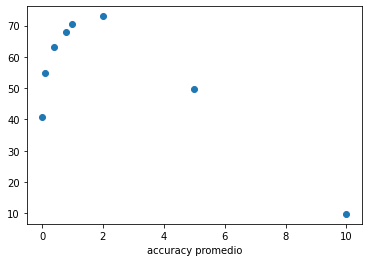

In [29]:
plt.scatter(lambda_list, avg_accurarers)
plt.xlabel('lambdas')
plt.xlabel('accuracy promedio')

**RESPUESTA 1** 
Interesantemente, hay un valor de lambda optimo donde el accuracy promedio es maximo. A mayor lambda que ese maximo empieza a bajar el accuracy. Es razonable ya que a mayor lambda, mayor importancia se le da a cada peso. Por esto si el lambda es muy grande, entonces muchos pesos se consideran importantes y no se cambian, por lo que la red no aprende nuevas tareas sino que se queda con los pesos de las tareas antiguas. 

**RESPUESTA 2** la funcion getsizeof muestra que este nuevo modelo tambien vale 64, como lo vimos en los ejercicios anteriores. 

In [31]:
import sys
sys.getsizeof(model)

64

## Comparación de Resultados
 
Para una mejor comparación de los métodos que vimos hoy en el laboratorio, vamos a graficar los resultados del accuracy promedio obtenido por los diferentes métodos, después de entrenar cada una de las tareas.
 
Con este gráfico estamos diciendo que no solo es importante no olvidar, sino que el poder aprender pesos que puedan servir a tareas futuras también es relevante.



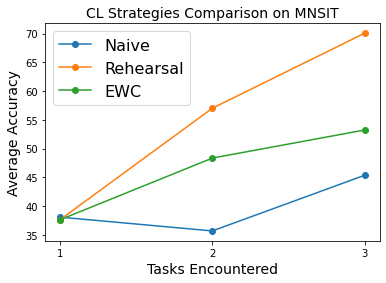

In [33]:
plt.plot([1, 2, 3], naive_accs, '-o', label="Naive")
plt.plot([1, 2, 3], rehe_accs, '-o', label="Rehearsal")
plt.plot([1, 2, 3], ewc_accs, '-o', label="EWC")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Strategies Comparison on MNSIT', fontsize=14);
plt.xticks([1, 2, 3])
plt.legend(prop={'size': 16});

### Actividad Práctica 4
 
*  Explique y haga una comparación entre los diferentes métodos mostrados en el gráfico anterior.
*  De ejemplos donde es mejor un método u otro. Explique sus razones.

**RESPUESTA**
El metodo Naive tiene el peor accuracy promedio porque cada vez que se entrena con una nueva tarea, se olvida de los pesos de las tareas anteriores. No es muy bueno aprendiendo nuevas tareas y manteniendo el accuracy de las tareas anteriores.

El metodo Rehearsal es mejor que Naive porque, al guardar algo de la data de la tarea anterior, al entrenarse con la data de la nueva tarea, parte de la data es de la tarea anterior. De esta manera se evita perder demasiado de los pesos de la tarea anterior. Por eso el accuracy promedio es mejor que en Naive.

El metodo EWC es el mejor de todos porque explicitamente busca los pesos mas importantes de la tarea anterior, y los guarda. De esta manera al entrenar en nuevas tareas, se mantienen los pesos importantes de tareas anteriores. Por eso EWC tiene el mejor accuracy promedio de los 3 metodos.

**EJEMPLOS** Naive seria mejor que el resto si en realidad lo unico que importa es aprender bien la nueva tarea, y las tareas anteriores ya no son relevantes. En este caso Naive seria mejor ya que todos los pesos se ajustan a la nueva tarea.
EWC es mejor cuando es importante que el modelo sea bueno en ambas la tarea nueva y las tareas anteriores.
Rehersal es un buen balance entre ambos.

# Privacidad
 
Uno de los factores más importantes en el mundo de hoy es la privacidad de los datos. Queremos que nuestros datos no sean compartidos con terceros, y si lo son, que estos sean compartidos de tal forma que no sea posible identificar lo que dicen a simple vista.
 
Tal como conversamos en clases, y hemos visto en este laboratorio, existen métodos que logran buenos resultados pero necesitan datos de las tareas anteriores para poder recordar la distribución que estos tenían.
 
Una alternativa a utilizar los datos duros del input, es utilizar un descriptor intermedio del modelo. Para esto debemos modificar el modelo para que nos devuelva un descriptor intermedio, y utilizar este para recordar tareas pasadas.

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        if x.size(1) != 320:
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
            x = x.view(-1, 320)
        feats = x.clone()
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x, feats

Al igual que el modelo, las funciones de entrenamiento deben cambiar para poder adaptarse al nuevo proceso, para aceptar inputs de diferentes tamaños. Por un lado vamos a tener los elementos de la tarea actual, y por otro lado los descriptores intermedios de las tareas anteriores.

In [33]:
def train_private(model, device, x_train, y_train, past_x, past_y, optimizer, epoch, prob = 0.5):
    model.train()
    feats_vects = []
    total_iter = int((len(y_train))/256) + int(len(past_y)/256)
    s_pres = 0
    s_past = 0
    for _ in range(total_iter+1):
        num = random.random()
        if (num < prob and s_pres < len(y_train)) or s_past >= len(past_y):
            start = s_pres
            end = start + 256
            x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(y_train[start:end]).long()
            s_pres += 256
        else:
            start = s_past
            end = start + 256
            x, y = torch.from_numpy(past_x[start:end]), torch.from_numpy(past_y[start:end]).long()
            s_past += 256
        x, y = x.to(device), y.to(device)
      
        optimizer.zero_grad()

        output, feats = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        if (num < prob and s_pres < len(y_train)) or s_past >= len(past_y):
            feats_vects.extend(feats.cpu().detach().numpy())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    return feats_vects

def test_private(model, device, x_test, y_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(y_test)-1, 256):
       end = start + 256
       with torch.no_grad():
          x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(y_test[start:end]).long()
          x, y = x.to(device), y.to(device)
          output,_ = model(x)
          test_loss += F.cross_entropy(output, y).item() # sum up batch loss
          pred = output.max(1, keepdim=True)[1] # get the index of the max logit
          correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(y_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(y_test),
        100. * correct / len(y_test)))
    return 100. * correct / len(y_test)

Tal como los procesos anteriores, debemos inicializar el modelo para que no tenga información adquirida por procesos anteriores.

In [34]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [35]:
import random

rehe_accs_priv = []
num_past_elem = 1000
feats_tasks = []

for id, task in enumerate(tasks):
    avg_acc = 0
    print("Training on task: ", id)
  
    (x_train, y_train), _ = task
  
    # for previous task
    past_x_train, past_y_train = [], []
    for i in range(id):
        (past_x, past_y) = feats_tasks[i]
        idx = random.sample(list(range(len(past_y))), num_past_elem)
        past_x_train.extend(past_x[idx])
        past_y_train.extend(past_y[idx])

    past_x_train = np.array(past_x_train)
    past_y_train = np.array(past_y_train)

    for epoch in range(1, num_epoch):
        feats = train_private(model, device, x_train, y_train, past_x_train, past_y_train, optimizer, epoch)
    feats_tasks.append([np.array(feats), y_train])
    
    for id_test, task in enumerate(tasks):
        print("Testing on task: ", id_test)
        _, (x_test, y_test) = task
        acc = test_private(model, device, x_test, y_test)
        avg_acc = avg_acc + acc
   
    print("Avg acc: ", avg_acc / len(tasks))
    rehe_accs_priv.append(avg_acc/len(tasks))

Training on task:  0
Train Epoch: 1 	Loss: 0.853645
Train Epoch: 2 	Loss: 0.629740
Testing on task:  0
Test set: Average loss: 0.0007, Accuracy: 9438/10000 (94%)

Testing on task:  1
Test set: Average loss: 0.0118, Accuracy: 624/10000 (6%)

Testing on task:  2
Test set: Average loss: 0.0100, Accuracy: 1275/10000 (13%)

Avg acc:  37.79
Training on task:  1
Train Epoch: 1 	Loss: 1.421765
Train Epoch: 2 	Loss: 1.033660
Testing on task:  0
Test set: Average loss: 0.0239, Accuracy: 1761/10000 (18%)

Testing on task:  1
Test set: Average loss: 0.0029, Accuracy: 7976/10000 (80%)

Testing on task:  2
Test set: Average loss: 0.0137, Accuracy: 800/10000 (8%)

Avg acc:  35.123333333333335
Training on task:  2
Train Epoch: 1 	Loss: 1.305927
Train Epoch: 2 	Loss: 0.947514
Testing on task:  0
Test set: Average loss: 0.0194, Accuracy: 1546/10000 (15%)

Testing on task:  1
Test set: Average loss: 0.0086, Accuracy: 2695/10000 (27%)

Testing on task:  2
Test set: Average loss: 0.0025, Accuracy: 8170/100

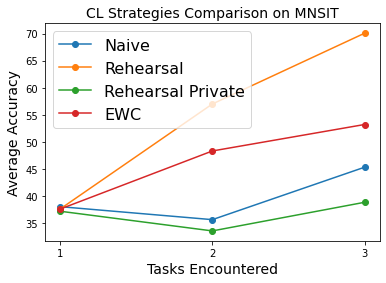

In [38]:
plt.plot([1, 2, 3], naive_accs, '-o', label="Naive")
plt.plot([1, 2, 3], rehe_accs, '-o', label="Rehearsal")
plt.plot([1, 2, 3], rehe_accs_priv, '-o', label="Rehearsal Private")
plt.plot([1, 2, 3], ewc_accs, '-o', label="EWC")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Strategies Comparison on MNSIT', fontsize=14);
plt.xticks([1, 2, 3])
plt.legend(prop={'size': 16});

## Actividad Práctica 5
 
* Explique porque la nueva versión de Rehersal (Rehearsal Private) no tiene buenos resultados comparados con la Rehearsal original.
* De alguna alternativa de cómo este proceso de entrenamiento pueda mejorar su resultado.

**RESPUESTA**
Rehearsal Private es peor que todos porque le estamos dado al modelo una representacion de las capas convolusionales que se olvida cuando se entrena la nueva tarea. Se podria mejorar al congelar las capas convolucionales antes de entrenarlas, similar que cuando uno hace transfer learning.